# Adding topography to geological models
***
This chapter shows how to make geological models look more realistic by incorporating topography data:
The data can either be stored in a raster file that can be conveniently loaded into gempy.
For demonstration purposes GemPy also provides a tool to create a random hilly landscape to limit the models on the surface.

***

In [1]:
import sys
sys.path.append("../..")

import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import os

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

### 1. The common procedure to set up a model:

In [2]:
geo_model = gp.create_model('Single_layer_topo')

gp.init_data(geo_model, extent=[450000, 460000, 70000,80000,-1000,500],resolution = (50,50,50),
                         path_i = os.pardir+"/data/input_data/tut-ch1-7/onelayer_interfaces.csv",
                         path_o = os.pardir+"/data/input_data/tut-ch1-7/onelayer_orient.csv")

Active grids: ['regular']


Single_layer_topo  2019-07-12 11:11

In [3]:
# use happy spring colors! 
geo_model.surfaces.colors.change_colors({'layer1':'#ff8000','basement':'#88cc60'})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,Default series,1,False,#ff8000,1
1,basement,Basement,1,True,#88cc60,2


In [4]:
%matplotlib inline
gp.map_series_to_surfaces(geo_model, {'series':('layer1','basement')})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,series,1,False,#ff8000,1
1,basement,series,2,True,#88cc60,2


In [5]:
s = {'s1': ([450000,75000],[460000,75500],[100,100])}
geo_model.grid.set_section_grid(s)

,start,stop,resolution
s1,"[450000, 75000]","[460000, 75500]","[100, 100]"


### 2. Adding topography

#### 2 a. Load from raster file

In [6]:
fp = os.pardir+"/data/input_data/tut-ch1-7/bogota.tif"

Cropped raster to geo_model.grid.extent.
[450000 460000  70000  80000] [167 167]
storing converted file...
Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[450100.        ,  70100.        ,   -985.        ],
       [450100.        ,  70100.        ,   -955.        ],
       [450100.        ,  70100.        ,   -925.        ],
       ...,
       [460000.        ,  75500.        ,    469.6969697 ],
       [460000.        ,  75500.        ,    484.84848485],
       [460000.        ,  75500.        ,    500.        ]])

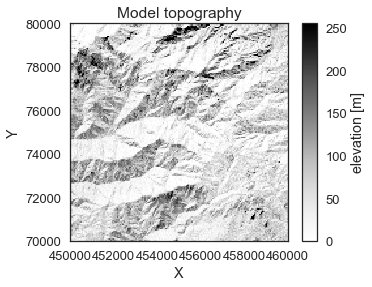

In [7]:
geo_model.set_topography(source='gdal',filepath=fp)

#### 2 b. create fun topography

If there is no topography file, but you think that your model with topography would look significantly cooler, you can use gempys function to generate a random topography based on a fractal grid:

Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[450100.        ,  70100.        ,   -985.        ],
       [450100.        ,  70100.        ,   -955.        ],
       [450100.        ,  70100.        ,   -925.        ],
       ...,
       [460000.        ,  75500.        ,    469.6969697 ],
       [460000.        ,  75500.        ,    484.84848485],
       [460000.        ,  75500.        ,    500.        ]])

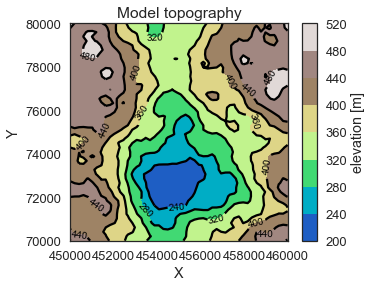

In [8]:
geo_model.set_topography(source='random')

It has additional keywords to play around with:
- fd: fractal dimension, defaults to 2.0. The higher (try 2.9), the rougher the landscape will be.
- d_z: height difference. If none, last 20% of the model in z direction.
- extent: extent in xy direction. If none, geo_model.grid.extent
- resolution: resolution of the topography array. If none, geo_model.grid.resoution. Increasing the resolution leads to much nicer geological maps!

Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[450100.        ,  70100.        ,   -985.        ],
       [450100.        ,  70100.        ,   -955.        ],
       [450100.        ,  70100.        ,   -925.        ],
       ...,
       [460000.        ,  75500.        ,    469.6969697 ],
       [460000.        ,  75500.        ,    484.84848485],
       [460000.        ,  75500.        ,    500.        ]])

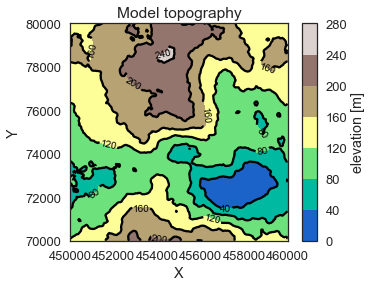

In [9]:
geo_model.set_topography(source='random',fd=1.9, d_z=np.array([0,250]), resolution=np.array([200,200]))

Note that each time this function is called, a new random topography is created. If you particularly like the generated topography or if you have loaded a large file with gdal, you can save the topography object and load it again later:

In [10]:
#save
geo_model.grid.topography.save('test_topo')

saved


Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[450100.        ,  70100.        ,   -985.        ],
       [450100.        ,  70100.        ,   -955.        ],
       [450100.        ,  70100.        ,   -925.        ],
       ...,
       [460000.        ,  75500.        ,    469.6969697 ],
       [460000.        ,  75500.        ,    484.84848485],
       [460000.        ,  75500.        ,    500.        ]])

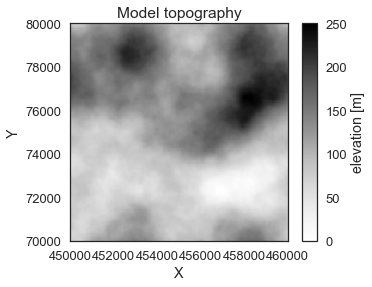

In [11]:
#load
geo_model.set_topography(source='saved',filepath='test_topo.npy')

### Compute model

In [8]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


In [51]:
gp.compute_model(geo_model, compute_mesh=False, set_solutions=True)


Lithology ids 
  [2. 2. 2. ... 1. 1. 1.] 

#### Visualize:
Now, the solutions object does also contain the computed geological map. It can be visualized using the plot_map function:

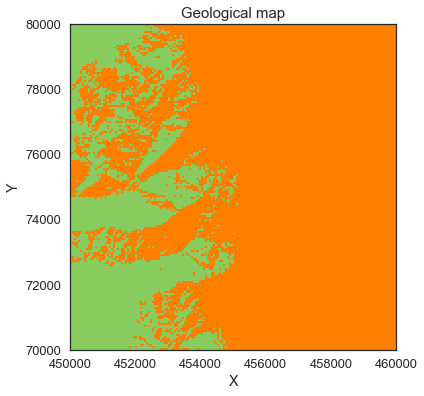

In [10]:
gp.plot.plot_map(geo_model, contour_lines=False, show_data=False)

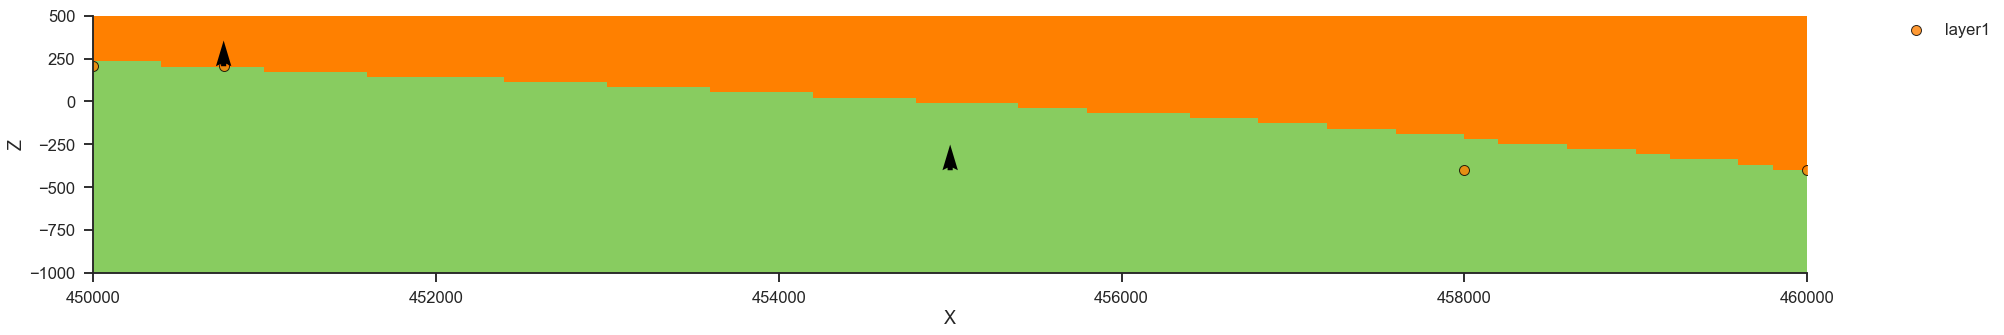

In [11]:
gp.plot.plot_section(geo_model, cell_number=4, block=geo_model.solutions.lith_block,
                         direction='y', show_data=True,show_faults=False)

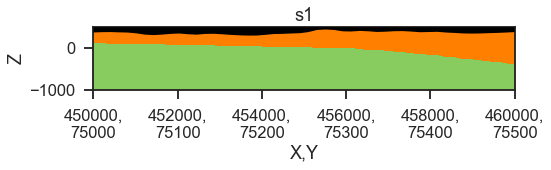

In [61]:
gp.plot.plot_predef_sections(geo_model,show_traces=False,figsize = (8,8))

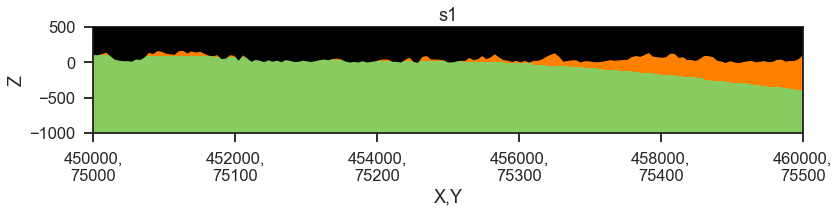

In [13]:
gp.plot.plot_predef_sections(geo_model, section_names=['s1'],show_traces=False)